# **PROJECT ARCHITECTURE**

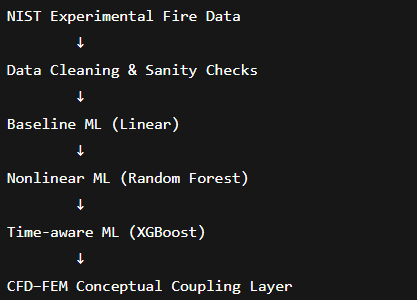

# **PART 1 — BASIC SETUP**

# **Import Libraries**

In [ ]:
# Numerical & data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Style
sns.set(style="whitegrid")


# **Load Dataset**

In [ ]:
file_path = "/content/1573757401_CompositeFloorTest_No1.csv"
df = pd.read_csv(file_path)

df.head()

,Time (s),Heat Release Rate (kW),NG Burner HRR (kW),Exhaust Mass Flow Rate (kg/s),Oxygen (Vol Fr),CO2 (Vol Fr),CO (Vol Fr),Radiant Heat Flux (kW/m^2),Ksmoke (1/m)
0,-634,0.66,-0.24,83.418,0.20942,0.000435,-0.000002,0.028951,NaN
1,-633,0.67,-0.24,83.418,0.20942,0.000435,-0.000002,0.028951,NaN
2,-632,0.92,-0.25,83.417,0.20942,0.000435,-0.000002,0.029111,NaN
3,-631,0.87,-0.23,83.416,0.20941,0.000435,-0.000002,0.028483,NaN
4,-630,0.77,-0.10,83.414,0.20941,0.000435,-0.000002,0.029215,NaN


# **Inspect & Clean Data**

In [ ]:
df.info()
df.describe()
df.isna().sum()
# Drop the 'Ksmoke (1/m)' column as it contains all NaN values
df = df.drop(columns=['Ksmoke (1/m)'], errors='ignore')
# Drop any remaining rows with missing values (if any other columns have NaNs)
df = df.dropna().reset_index(drop=True)
print("DataFrame shape after cleaning:", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9059 entries, 0 to 9058
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Time (s)                       9059 non-null   int64  
 1   Heat Release Rate (kW)         9059 non-null   float64
 2   NG Burner HRR (kW)             9059 non-null   float64
 3   Exhaust Mass Flow Rate (kg/s)  9059 non-null   float64
 4   Oxygen (Vol Fr)                9059 non-null   float64
 5   CO2 (Vol Fr)                   9059 non-null   float64
 6   CO (Vol Fr)                    9059 non-null   float64
 7   Radiant Heat Flux (kW/m^2)     9059 non-null   float64
 8   Ksmoke (1/m)                   0 non-null      float64
dtypes: float64(8), int64(1)
memory usage: 637.1 KB
DataFrame shape after cleaning: (9059, 8)


# **PART 2 — ML SURROGATE CORE**

# **Define Inputs & Output**

In [ ]:
# Check exact column names
print(df.columns.tolist())

['Time (s)', 'Heat Release Rate (kW)', 'NG Burner HRR (kW)', 'Exhaust Mass Flow Rate (kg/s)', 'Oxygen (Vol Fr)', 'CO2 (Vol Fr)', 'CO (Vol Fr)', 'Radiant Heat Flux (kW/m^2)']


In [ ]:
df = df.dropna().reset_index(drop=True)
print("After cleaning:", df.shape)

After cleaning: (9059, 8)


In [ ]:
target_col = "Radiant Heat Flux (kW/m^2)"

X = df.drop(columns=[target_col])
y = df[target_col]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (9059, 7)
y shape: (9059,)


# **Train–Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (7247, 7)
Test size: (1812, 7)


# **Scaling**

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Baseline Model — Linear Regression**

In [ ]:
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)

y_pred_lin = lin_model.predict(X_test_scaled)

# **Nonlinear Surrogate — Random Forest**

In [ ]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# **Evaluation Function**

In [ ]:
def evaluate(y_true, y_pred, name):
    print(f"\n{name}")
    print("MAE :", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R²  :", r2_score(y_true, y_pred))
evaluate(y_test, y_pred_lin, "Linear Regression")
evaluate(y_test, y_pred_rf, "Random Forest")


Linear Regression
MAE : 0.2779075787024107
RMSE: 0.3863581758536074
R²  : 0.9749287622233446

Random Forest
MAE : 0.08169669513245038
RMSE: 0.14217097659867936
R²  : 0.9966051745032555


# **Prediction Plot**

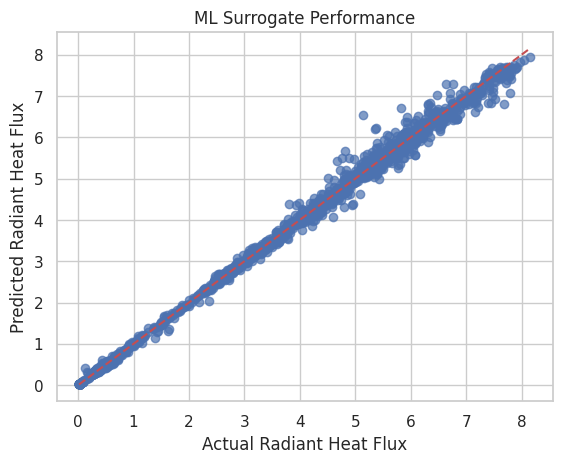

In [ ]:
plt.scatter(y_test, y_pred_rf, alpha=0.7)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Radiant Heat Flux")
plt.ylabel("Predicted Radiant Heat Flux")
plt.title("ML Surrogate Performance")
plt.show()

# **PART 3 — TIME-AWARE ML (XGBOOST)**

# **Install XGBoost and Time-Series Feature Construction**

In [ ]:
!pip install xgboost
# Sort by time
df = df.sort_values("Time (s)")

# Lag features (previous timestep)
for col in X.columns:
    df[f"{col}_lag1"] = df[col].shift(1)

df = df.dropna().reset_index(drop=True)

# **XGBoost Surrogate**

In [ ]:
from xgboost import XGBRegressor

X_ts = df.drop(columns=[target_col]) # Use the correct target_col
y_ts = df[target_col] # Use the correct target_col

X_train, X_test, y_train, y_test = train_test_split(
    X_ts, y_ts, test_size=0.2, random_state=42
)

xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

evaluate(y_test, y_pred_xgb, "XGBoost Time-Aware Model")


XGBoost Time-Aware Model
MAE : 0.12656760320585553
RMSE: 0.2093805273175898
R²  : 0.992652866753553


# **PART 4 — CFD–FEM CONCEPTUAL COUPLING**

In [ ]:
def cfd_fem_surrogate(fire_inputs):
    """
    fire_inputs: dict with fire conditions
    returns: predicted radiant heat flux
    """

    # Convert input dictionary to DataFrame
    input_df = pd.DataFrame([fire_inputs])

    # Ensure column order matches training data
    input_df = input_df[X.columns]

    # Predict using trained surrogate model
    prediction = rf_model.predict(input_df)[0]

    return prediction


# -----------------------------------------
# Example Fire Scenario (Conceptual CFD Output)
# -----------------------------------------

example_fire_case = {
    "Time (s)": 600,
    "Heat Release Rate (kW)": 2500,
    "NG Burner HRR (kW)": 2000,
    "Exhaust Mass Flow Rate (kg/s)": 12.0,
    "Oxygen (Vol Fr)": 0.14,
    "CO2 (Vol Fr)": 0.08,
    "CO (Vol Fr)": 0.004,
    "Ksmoke (1/m)": 2.5
}

# Run surrogate
predicted_rhf = cfd_fem_surrogate(example_fire_case)

# -----------------------------------------
# PRINT FINAL RESULT
# -----------------------------------------

print("----- CFD–FEM ML Surrogate Result -----")
print("Input fire scenario:")
for k, v in example_fire_case.items():
    print(f"  {k}: {v}")

print("\nPredicted Radiant Heat Flux:")
print(f"  {predicted_rhf:.2f} kW/m²")

print("\nInterpretation:")
print(
    "This ML surrogate replaces a CFD fire simulation step by "
    "rapidly estimating the radiant heat flux, which can be "
    "used as a thermal boundary condition for FEM-based "
    "structural analysis."
)


----- CFD–FEM ML Surrogate Result -----
Input fire scenario:
  Time (s): 600
  Heat Release Rate (kW): 2500
  NG Burner HRR (kW): 2000
  Exhaust Mass Flow Rate (kg/s): 12.0
  Oxygen (Vol Fr): 0.14
  CO2 (Vol Fr): 0.08
  CO (Vol Fr): 0.004
  Ksmoke (1/m): 2.5

Predicted Radiant Heat Flux:
  2.82 kW/m²

Interpretation:
This ML surrogate replaces a CFD fire simulation step by rapidly estimating the radiant heat flux, which can be used as a thermal boundary condition for FEM-based structural analysis.
